## Network modeling

In this session we will examine methods for characterizing the higher-order structure of a network.  

### Community detection

A common feature of real-world networks is that they exhibit *community structure* - that is, there are groups of individuals who are heavily connected to each other and much less heavily connected to node in other communities. Another way to put this is that edges are *clustered* - and in fact community detection is similar in spirit to clustering.


Let's start with our example of network neuroscience researchers from last week

In [1]:
import os
import pandas,numpy
import networkx as nx
import itertools
from Bio import Entrez
import scipy.cluster,scipy.spatial
import pickle
import infomap
import igraph
import matplotlib.pyplot as plt
import sklearn
import random

import sys
sys.path.append('../utils')
from utils import get_joint_pubs,nx_to_igraph,module_degree_zscore,participation_coefficient,get_pubdata

%matplotlib inline

In [2]:
# If the publication data are cached then load those and use them
# instead of getting them from pubmed

researchers={'DB':{'name':'Danielle Bassett'},
            'AF':{'name':'Alex Fornito'},
            'MB':{'name':'Michael Breakspear'},
            'SP':{'name':'Steve Petersen'},
            'MC':{'name':'Michael Cole'},
            'JP':{'name':'Jonathan Power'},
            'DF':{'name':'Damien Fair'},
            'AZ':{'name':'Andrew Zalesky'}}


numpubs=get_pubdata(researchers)

# create a list to use in making the matrix
# do this so that the order stays fixed
researchers_list=list(researchers.keys()) 

# create a data frame to hold all of the entries
# for each combination of researchers

df=pandas.DataFrame(numpy.zeros((len(researchers),
                                 len(researchers))),
                   index=researchers_list,
                   columns=researchers_list)

# we just fill in the upper triangle of the matrix
for i,j in enumerate(researchers_list):
    for k in range(i,len(researchers_list)):
        if i==k:
            continue
        df.loc[j][k]=numpubs[(j,researchers_list[k])]

print(df)

# make binary adjacency matrix
threshold=0
adjacency_mtx=(df>threshold).astype('int')
print(adjacency_mtx)



     DB   AF   MB   SP   MC    JP    DF    AZ
DB  0.0  2.0  1.0  1.0  3.0   2.0   0.0   1.0
AF  0.0  0.0  4.0  0.0  0.0   0.0   0.0  28.0
MB  0.0  0.0  0.0  0.0  0.0   0.0   0.0  13.0
SP  0.0  0.0  0.0  0.0  1.0  27.0  15.0   0.0
MC  0.0  0.0  0.0  0.0  0.0   2.0   0.0   0.0
JP  0.0  0.0  0.0  0.0  0.0   0.0   3.0   0.0
DF  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0
AZ  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0
    DB  AF  MB  SP  MC  JP  DF  AZ
DB   0   1   1   1   1   1   0   1
AF   0   0   1   0   0   0   0   1
MB   0   0   0   0   0   0   0   1
SP   0   0   0   0   1   1   1   0
MC   0   0   0   0   0   1   0   0
JP   0   0   0   0   0   0   1   0
DF   0   0   0   0   0   0   0   0
AZ   0   0   0   0   0   0   0   0


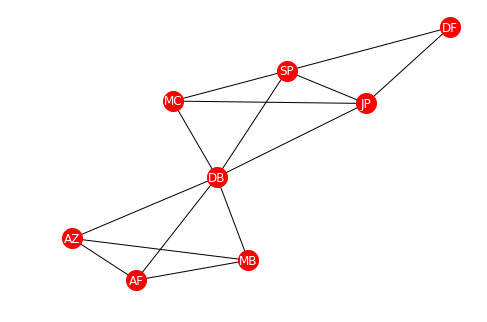

In [3]:
# create network

G = nx.Graph()

G.add_nodes_from(researchers.keys())

matches=numpy.where(adjacency_mtx>0)
for i in range(len(matches[0])):
    G.add_edge(researchers_list[matches[0][i]],
               researchers_list[matches[1][i]])

nx.draw_spring(G,with_labels=True,node_size=400,font_color='white')


Looking at this figure we see a couple of things.  First, we see that there are two communities that are highly connected within each other but relatively unconnected between one another.  Second, we see that there is one person (Dani Bassett) who is highly connected to people in both of those groups.  Let's now look at how we can describe these features using graph theory.

First let's use a standard hierarhical clustering technique to look at the data.  To compute the clustering solution we need a distance measure between individuals - we will use the shortest path between each pair of individuals as the distance measure.  

In [4]:
p = nx.shortest_path(G)
shortest_path_mat = numpy.zeros((len(G.nodes),len(G.nodes)))

for i,node in enumerate(G.nodes):
    for j,target in enumerate(G.nodes):
        if i==j:
            continue
        shortest_path_mat[i, j] = len(list(p[node][target]))-1

shortest_path_df=pandas.DataFrame(shortest_path_mat,columns=G.nodes,index=G.nodes)
shortest_path_df

,DB,AF,MB,SP,MC,JP,DF,AZ
DB,0.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
AF,1.0,0.0,1.0,2.0,2.0,2.0,3.0,1.0
MB,1.0,1.0,0.0,2.0,2.0,2.0,3.0,1.0
SP,1.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0
MC,1.0,2.0,2.0,1.0,0.0,1.0,2.0,2.0
JP,1.0,2.0,2.0,1.0,1.0,0.0,1.0,2.0
DF,2.0,3.0,3.0,1.0,2.0,1.0,0.0,3.0
AZ,1.0,1.0,1.0,2.0,2.0,2.0,3.0,0.0


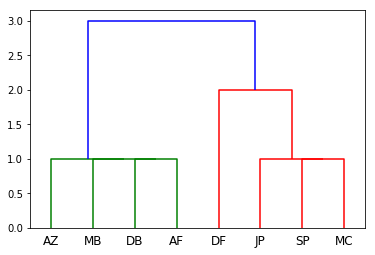

In [5]:
dist=scipy.spatial.distance.squareform(shortest_path_df)
# create linkage and plot dendrogram
Z = scipy.cluster.hierarchy.linkage(dist, 'complete')
dn = scipy.cluster.hierarchy.dendrogram(Z,labels=adjacency_mtx.columns)

This figure captures some of the features of the graph above, and if we cut the graph at the right point we could create two clusters that would map onto the communities that are clear from the spring-embedded graph.  However, it's clearly misleading in its presentation of node DB - looking at this representation we would have no idea that DB actually sits between the two clusters.  

Now let's see what happens when we use a graph-theoretic method for community detection. We will use the Girvan-Newman method, which is succinctly described in the networkx documentation:

>The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality, at each step. As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.

In this case we know that there should be two communities, so we will simply use the algorithm to find the first breakdown into two communities.



In [6]:
comp = nx.algorithms.community.centrality.girvan_newman(G)

# the function creates an iterator, so grab the first item
communities = tuple(sorted(c) for c in next(comp))

# create a partition variable that we can use for labeling the graph
partition=pandas.DataFrame(numpy.zeros(adjacency_mtx.shape[0]),
                          index=adjacency_mtx.columns,columns=['GN'])
for i,c in enumerate(communities):
    partition.loc[c]=i
partition

,GN
DB,0.0
AF,0.0
MB,0.0
SP,1.0
MC,1.0
JP,1.0
DF,1.0
AZ,0.0


Now let's plot the spring-embedded graph using the community partition to color the nodes:

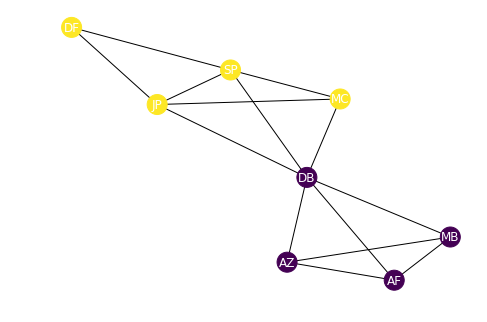

In [7]:
nx.draw_spring(G,with_labels=True,
               node_size=400,
               font_color='white',
               node_color=partition.values)


This shows that the partition found by the Girvan-Newman algorithm identifies the two major communities that are visually evident in the graph.  

It is worth noting that in general one doesn't necessarily know the "right" number of communities in a network, so we generally have to use methods that try to determine the number of communities.  However, like determining the number of clusters in a clustering problem, there is no single right answer for the number of communities.  See [this paper](http://proceedings.mlr.press/v27/luxburg12a/luxburg12a.pdf) for a deeper discussion of this issue in the context of clustering.

### Community detection in complex neworks

Now let's look at a more complex network. For this example we will use a dataset created from PubMed (generated using copub_analysis.py), which represents the co-authorship data for all papers from a selected set of journals that matched the search term ```"resting state" AND "fMRI" AND "connectivity"```.  



In [8]:
def get_copub_data():
    return(pickle.load(open('../data/pubmed/copub_data.pkl','rb')))
copub,all_author_names,orcid_dict=get_copub_data()

# generate a networkx graph
G_copub=nx.Graph()
for i in copub:
    G_copub.add_edges_from([i])


In the example above, all of the nodes were connected to one another.  However, it's common in real networks for there to be some nodes that are completely disconnected from the rest of the network.  These are referred to as *components* of the graph.  This is evident if we plot the data:

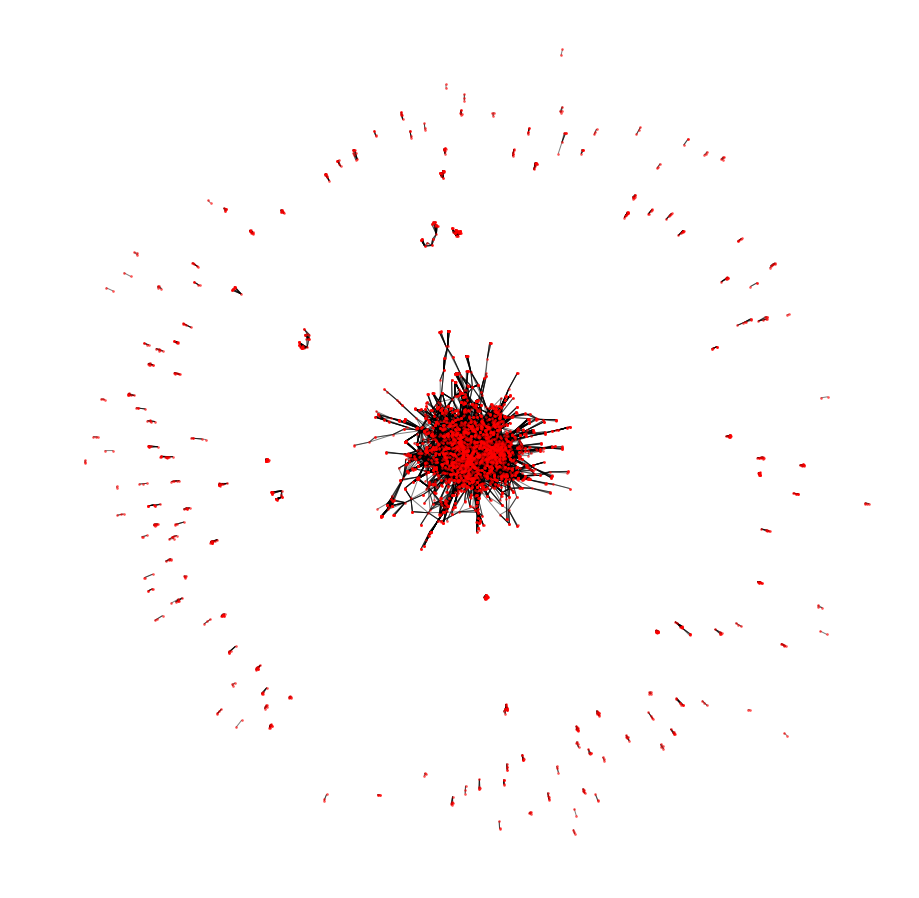

In [9]:
plt.figure(figsize=(12,12))
nx.draw_spring(G_copub,node_size=3,alpha=0.5)

You can see that there is one large connected component in the middle of the graph, which we refer to as the *giant component*.  However, there are also many smaller components that are not connected by any edges to the giant component.  Because many algorithms will fail in this case (e.g. any algorithm that requires measuring path lengths, because there are no paths between nodes in disconnected components and thus the path length is infinite), it's common to focus our analyses only on the giant component, which we will do here.

In [10]:
components = sorted(nx.connected_component_subgraphs(G_copub), key = len, reverse=True)
print('found',len(components),'components')

# create variable for giant component
Gc_copub = components[0]
print(len(Gc_copub.nodes),'authors in giant component')

found 150 components
3958 authors in giant component


### Modularity 

One of the most common methods for community detection relies upon the concept of modularity, which is a metric that quantifies the degree to which the number of edges within communities exceeds that expected in a random network of similar size and density.  See [Mark Newman's classic paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1482622/) for a deeper discussion.   

#### DIG DEEPER INTO MODULARITY?

A general strategy for community detection is to find the partition that maximizes modularity.  There are a number of methods that can be used to find the network partition that maximizes modularity; this is a hard problem ([actually, it's NP-complete](https://www.uni-konstanz.de/mmsp/pubsys/publishedFiles/BrDeGa08.pdf)), so most methods use a heuristic approach.  The NetworkX toolbox doesn't include very many of these, but the iGraph toolbox [includes a number of the popular tools for community detection](http://igraph.org/c/doc/igraph-Community.html), so let's use that toolbox instead.  We will use the *multilevel* method [described by Blondel and colleagues](https://arxiv.org/pdf/0803.0476.pdf).  



In [11]:
ig_copub = nx_to_igraph(Gc_copub) 

ml=ig_copub.community_multilevel()
communities=numpy.unique(ml.membership)
print('Louvain method found %d communities'%len(communities))
#for i in communities:
#    print('%d: %d members'%(i,numpy.sum(ml.membership==i)))

Louvain method found 41 communities


Note that we will use the terms *community* and *module* interchangeably in our discussion.

Let's plot the spring embedded graph coloring the different communities.

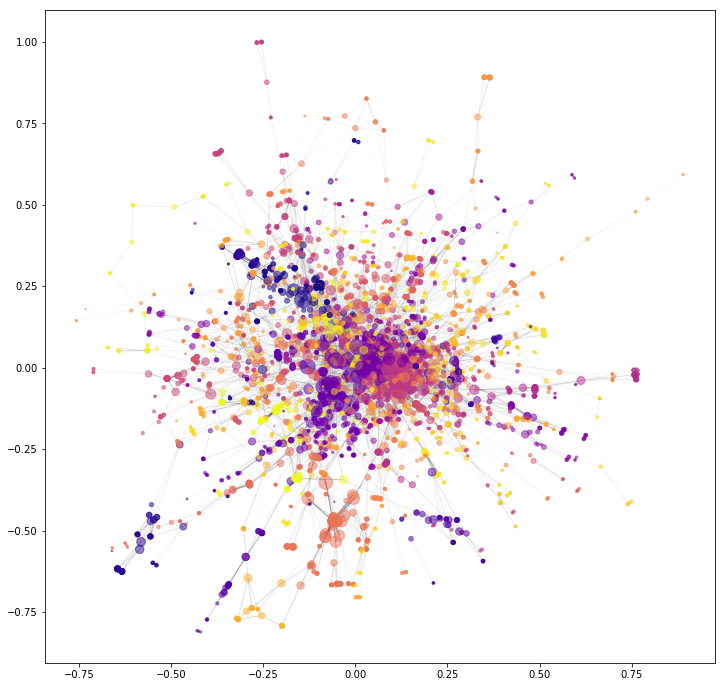

In [12]:
plt.figure(figsize=(12,12))
pl=nx.spring_layout(Gc_copub)

nx.draw_networkx(Gc_copub,pos=pl,node_size=0,
                 with_labels=False,
                 alpha=0.005,
                node_color='black')
expansion=2
nx.draw_networkx_edges(Gc_copub,pos=pl,edge_color='black',alpha=0.01)
nx.draw_networkx_nodes(Gc_copub,pos=pl,
                          node_size=[Gc_copub.degree[n]*expansion for n in Gc_copub.nodes],
                           node_color=ml.membership,cmap='plasma',alpha=0.5)


Given this community partition we can also compute the modularity value directly:

In [13]:
ig_copub.modularity(ml)

0.8176999661732016

This value is quite high (cf. see [Table 1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1482622/table/T1/) of Newman's 2006 PNAS paper), suggesting that there is indeed a strong degree of modular organization in the data.

It can also be usefult to visualize the adjacency matrix after sorting by module assignment. 

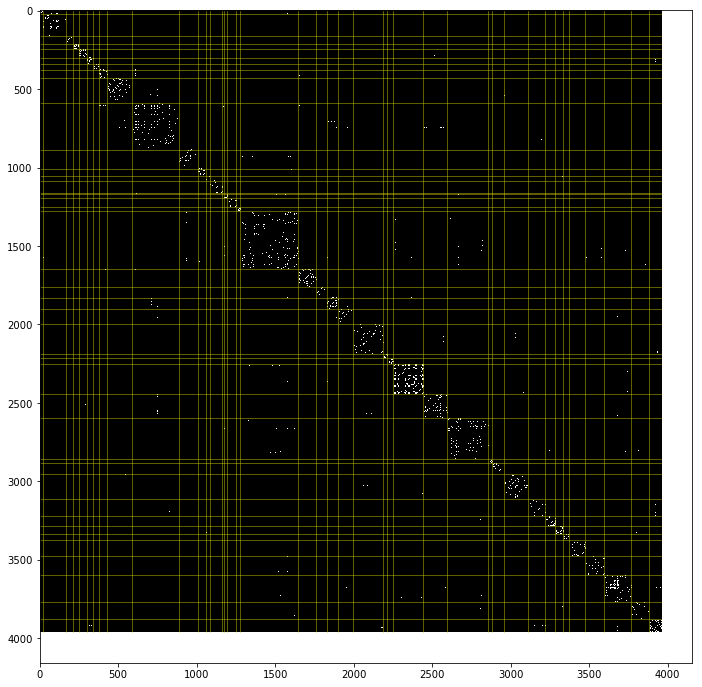

In [14]:
plt.figure(figsize=(12,12))
adjacency_mtx=nx.to_numpy_array(Gc_copub)
module_idx=numpy.argsort(ml.membership)
membership_sorted=numpy.array(ml.membership)[module_idx]
adjacency_mtx_sorted=adjacency_mtx[:,module_idx]
adjacency_mtx_sorted=adjacency_mtx_sorted[module_idx,:]
plt.imshow(adjacency_mtx_sorted,cmap='gray')

# draw lines to demarcate modules
for i in range(1,len(membership_sorted)):
    if membership_sorted[i]!=membership_sorted[i-1]:
        plt.plot([0,len(membership_sorted)],[i,i],color='y',linewidth=0.5)
        plt.plot([i,i],[0,len(membership_sorted)],color='y',linewidth=0.5)

Here we can see that there seems to be a greater degree of co-publication within modules than between modules, which is essentially the definition of modularity.

### Infomap

Another commonly used method for community detection in neuroimaging is the [Infomap algorithm](http://www.mapequation.org/code.html), which is also implemented in iGraph. 

In [15]:
infomap_result = ig_copub.community_infomap()

In [16]:
unique_partitions=numpy.unique(infomap_result.membership)
print('Infomap method found %d communities'%len(unique_partitions))


Infomap method found 249 communities


As we see, the infomap method finds substantially more clusters than the modularity-based method.  This highlights one limitation of modularity-based approaches, known as the ["resolution limit"](http://www.pnas.org/content/104/1/36), which prevents them from identifying small clusters (where "small" depends on the size of the network and the degree to which the modules are interconnected). 



### Network hubs

We know that in any group there are some individuals who are better connected than others, and this was evident from the long-tailed degree distrbution in the Facebook data.  In network science, such high-degree nodes are often referred to as "hubs".  Given our characterization of community structure, we can further differentiate between different types of hubs.  Some hubs are both highly connected within their own module and to nodes in other modules, which we refer to as *connector hubs*.  Other hubs are highly connected, but primarily to other nodes within their own module, which we refer to as *provincial hubs*.  These different types of hubs play different roles in network communication, and we will encounter them repeatedly as we discuss network neuroscience research. 

To examine this, let's look at a more realistic network of research publications. To do this, we will search on a set of researchers in the field and find all of their coauthors, and then map their co-publication network.



A general approach to categorizing different types of hubs was presented by [Guimera and Amaral (2005)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2175124/), known as "cartographic analysis".  This involves computing two node-level measures:

- within-module degree Z-score: The number of edges between a node and other nodes within its module, Z-scored across all members of that module. 

- participation coefficient: A measure of the squared proportion of edges that are with nodes outside one's own module.

$$P_i = 1 - \sum_{s=1}^{N_M} \left ( \frac{k_{is}}{k_i} \right )^2$$

$k_{is}$ is the number of edges that fall within one's module (i.e. module degree), and $k_i$ is the total number of edges (i.e.  degree).

Let's compute these for this dataset, using functions defined in utils/utils.py

In [17]:
mdzs=module_degree_zscore(Gc_copub, ml.membership)
pc=participation_coefficient(Gc_copub,ml.membership)

We can plot participation against module degree z-score to obtain a *cartographic profile*.  Guimera & Amaral defined any node with a module degree Z-score greater than 2.5 as being a *hub*, and further distinguished between three types of hubs:

- *Provincial hubs*: These are hubs that have most of their edges (> ~$\frac{5}{6}$) within their module.
- *Connector hubs*: These are hubs with at least half of their edges within their module.
- *Kinless hubs*: These are highly connected nodes that are not tightly bound to any specific module.



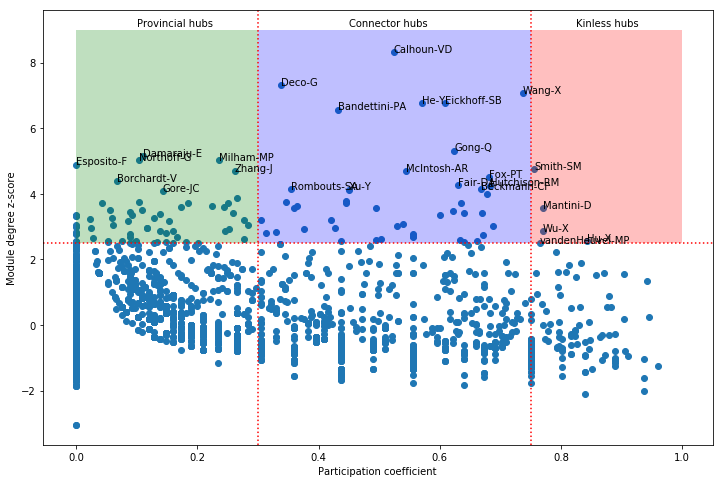

In [18]:
# put everything into a data frame
cartography=pandas.DataFrame(numpy.vstack((pc,
                                           mdzs,
                                           module_degree_zscore(Gc_copub,ml.membership,zscore=False))).T,
                             columns=['PC','MDZS','ModDegree'],
                            index=Gc_copub.nodes)

plt.figure(figsize=(12,8))
plt.scatter(cartography.PC,cartography.MDZS)
ax=plt.gca()

# print names for certain hubs
for i, txt in enumerate(cartography.index):
    if  cartography.MDZS[i]>4 or (cartography.MDZS[i]>2.5 and cartography.PC[i]>0.75):
        ax.annotate(txt, (cartography.PC[i], cartography.MDZS[i]))
        
# add lines and anntation for Guimera/Amaral regions
plt.axvline(0.75, color='r',linestyle='dotted')
plt.axvline(0.3, color='r',linestyle='dotted')
plt.axhline(2.5, color='r',linestyle='dotted')
plt.xlabel('Participation coefficient')
plt.ylabel('Module degree z-score')
ymax=9
ax.fill_between([0,0.3], [2.5,2.5],[ymax,ymax], facecolor='green', alpha=0.25)
ax.fill_between([0.3,0.75], [2.5,2.5],[ymax,ymax], facecolor='blue', alpha=0.25)
ax.fill_between([0.75,1.], [2.5,2.5],[ymax,ymax], facecolor='red', alpha=0.25)
plt.annotate('Provincial hubs',[0.1,ymax+0.1])
plt.annotate('Connector hubs',[0.45,ymax+0.1])
plt.annotate('Kinless hubs',[0.825,ymax+0.1])


### Rich clubs

It is common in real-world networks for the hubs in the network to also be strongly connected to one another, which is known as the [*rich club* phenomenon](https://en.wikipedia.org/wiki/Rich-club_coefficient).  An important aspect of rich-club behavior is that it makes the network more resilient to damage compared to a network with hubs that are not tightly interconnected.

The presence of a rich club can be estimated using the *rich club coefficient*, which indicates for a given degree what proportion of possible edges are present between nodes of that degree or greater. We can compute this using the ```rich_club_coefficient()``` function in NetworkX, which allows computation of a normalized version of the measure, for which the presence of a rich club is denoted by values greater than 1.

rcc computation failed, rerunning...
rcc computation failed, rerunning...


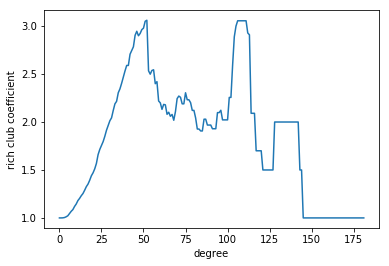

In [21]:
good_rcc=False
while not good_rcc:
    try:
        rcc=nx.rich_club_coefficient(Gc_copub,normalized=True,Q=10)
        good_rcc=True
    except ZeroDivisionError:
        print('rcc computation failed, tryimg again...')

# put into a data frame since function returns a dict
rcc_df=pandas.DataFrame([rcc[i] for i in rcc],columns=['rcc'])

plt.plot(rcc_df)
plt.xlabel('degree')
plt.ylabel('rich club coefficient')


This shows us that there is substantial evidence for rich club behavior, seemingly even stronger than that shown for scientific collaborations by [McCauley et al.](https://arxiv.org/pdf/physics/0701290.pdf).  

Let's have a look at the structure of the highly connected nodes in the network, looking at the nodes that have at least k=75, at which rich club behavior seems strong and the group will be small enough to easily visualize.

In [22]:
# create a new graph with only the high degree nodes
G_highdegree=Gc_copub.copy()
deg = dict(G_highdegree.degree())
cutoff=75 
to_remove = [n for n in deg if deg[n] <= cutoff]

G_highdegree.remove_nodes_from(to_remove)


Plot the rich club overlaid on the full network.  

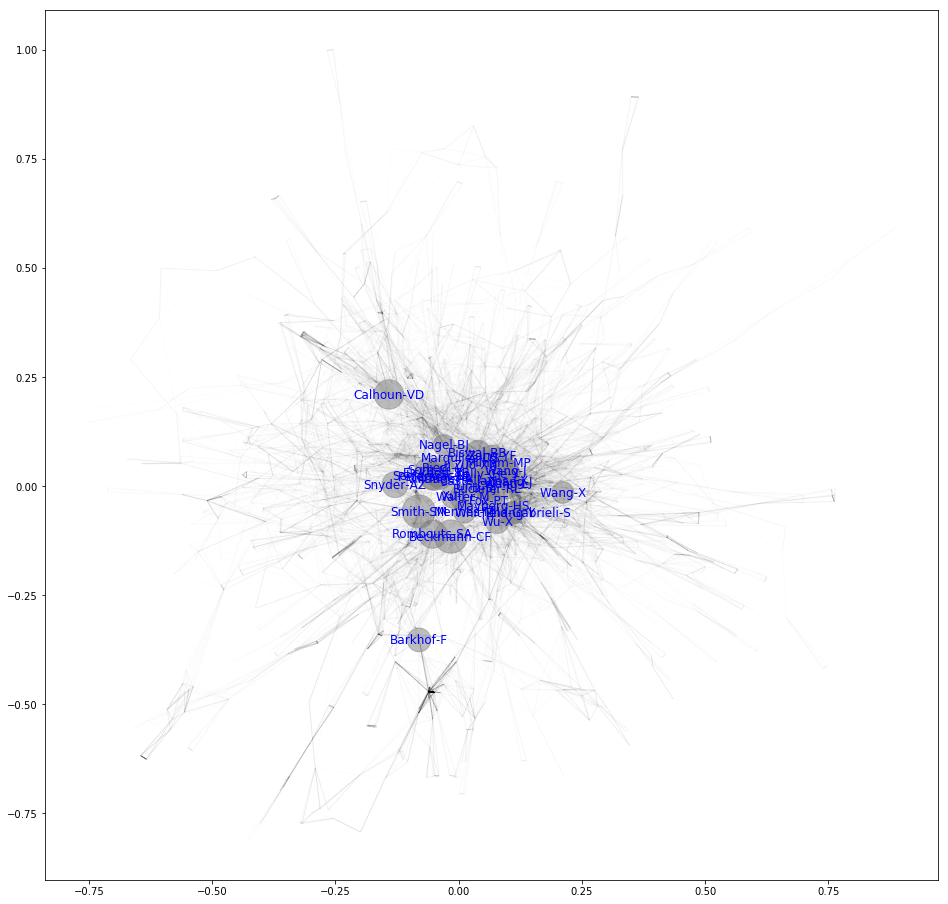

In [23]:
plt.figure(figsize=(16,16))
# first plot the edges for the full network with a very low alpha
nx.draw_networkx(Gc_copub,pos=pl,node_size=0,
                 with_labels=False,
                 alpha=0.01,
                node_color='black')

# plot the high degree nodes, scaling size by degree
expansion=6
nx.draw_networkx_nodes(G_highdegree,pos=pl,
                      node_size=[Gc_copub.degree[n]*expansion for n in G_highdegree.nodes],
                       node_color='gray',alpha=0.5)
# plot the labels 
_=nx.draw_networkx_labels(G_highdegree,
                   pos=pl,
                   font_color='blue')
# plot the high degere edges
_=nx.draw_networkx_edges(G_highdegree,pos=pl,edge_color='white',alpha=0.5)


We can also plot just the rich club nodes, to see them in detail.

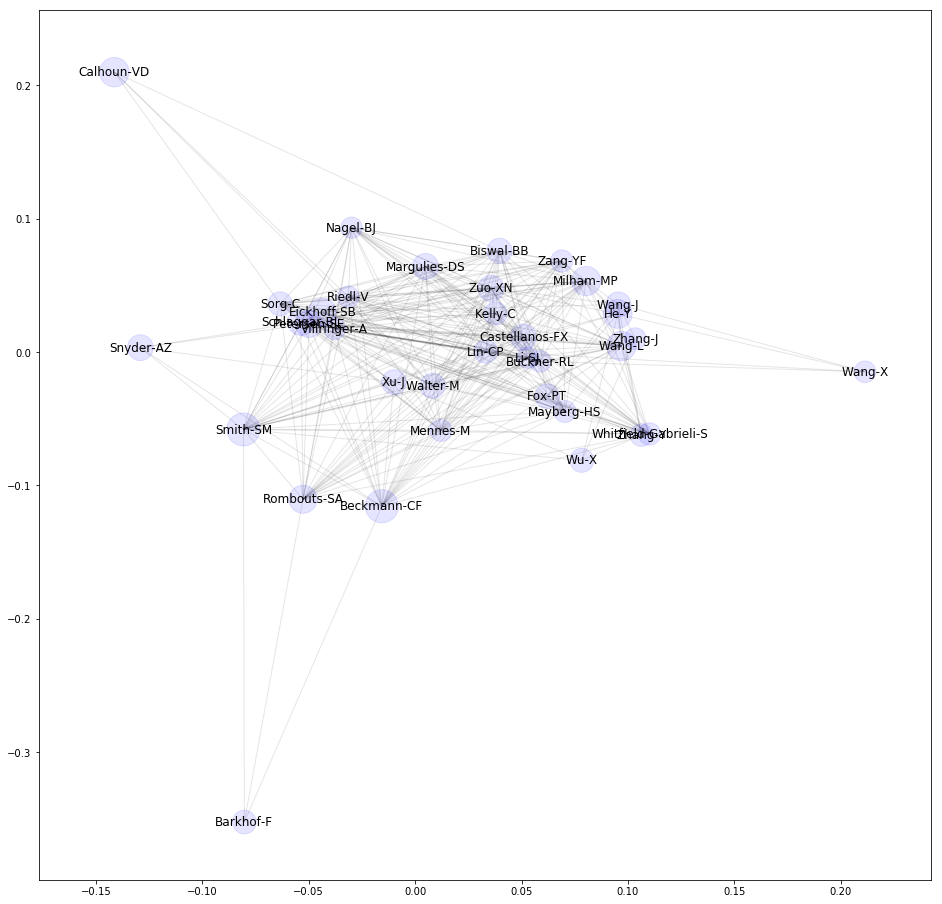

In [24]:
plt.figure(figsize=(16,16))

_=nx.draw_networkx(G_highdegree,pos=pl,
                 node_size=[Gc_copub.degree[n]*expansion for n in G_highdegree.nodes],
                node_color='blue',with_labels=False,alpha=0.1,font_size=6)
_=nx.draw_networkx_labels(G_highdegree,pos=pl)

### k-core decomposition

Another way to visualize the core of a network is to perform *k-core decomposition*, which identifies the largest possible subgraph for which all members have degree of at least k.  We will use k=53, which is the largest value for which a k-core exists for this dataset.



In [25]:
G_kcore=nx.k_core(Gc_copub,53)

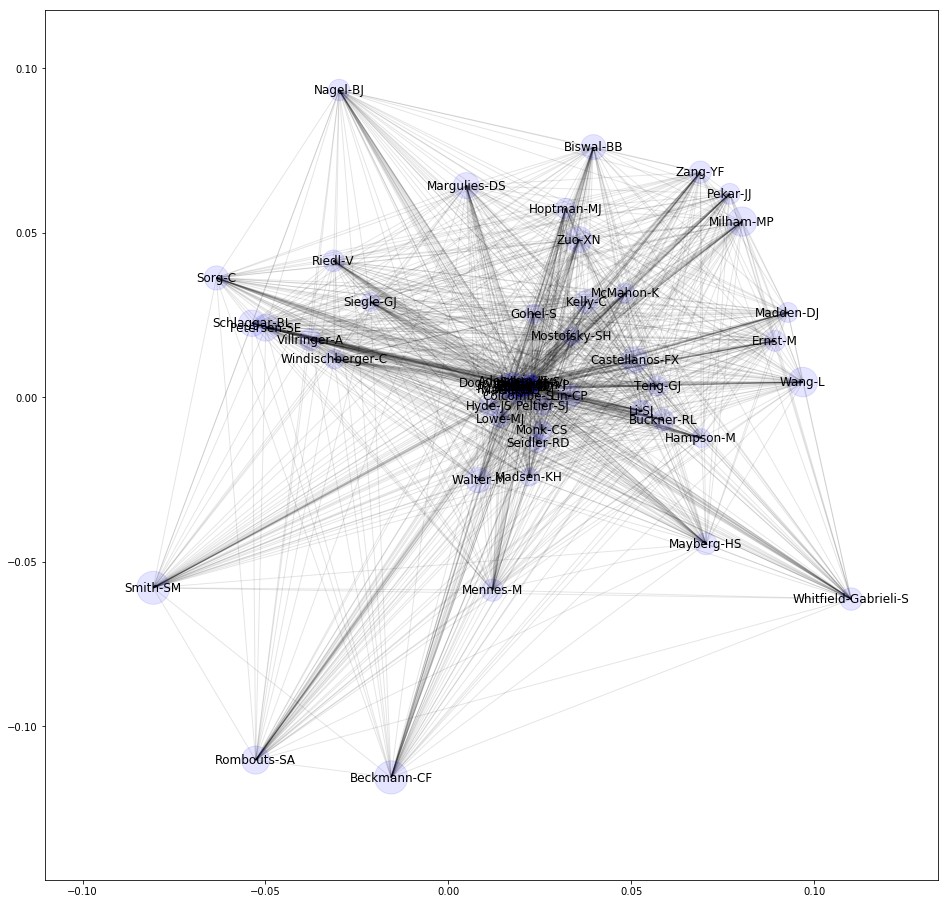

In [26]:
plt.figure(figsize=(16,16))
_=nx.draw_networkx(G_kcore,pos=pl,
                 node_size=[Gc_copub.degree[n]*expansion for n in G_kcore.nodes],
                node_color='blue',with_labels=False,alpha=0.1,font_size=8)
_=nx.draw_networkx_labels(G_kcore,pos=pl)

Note that this set is much more densely connected than the set of items found using the rich club analysis above, which highlights the differences in how these different methods will select items.